# Interconnect  - Churn prediction of clients

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.


### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

### Task:

Analyze the data and build a model to forecast Interconnect clients' churn - in order to contact them in advance with promotions and keep them longer as clients.

In [1]:
!pip install -U seaborn

In [2]:
#importing libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

import numpy as np
import math as mth

from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import re

#importing models:
from sklearn.linear_model import LinearRegression

#importing metrics,scaler and models methods:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV




In [3]:
#importing the data:

try:
    contract = pd.read_csv('C:\\Users\\ory_s\\Practicum100\\final_provider\\final_provider\\contract.csv')
    personal = pd.read_csv('C:\\Users\\ory_s\\Practicum100\\final_provider\\final_provider\\personal.csv')
    internet = pd.read_csv('C:\\Users\\ory_s\\Practicum100\\final_provider\\final_provider\\internet.csv')
    phone = pd.read_csv('C:\\Users\\ory_s\\Practicum100\\final_provider\\final_provider\\phone.csv')
    
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')



In [4]:
#creating a function to help with the exploration of the datasets:
def explore(df):
    display(df.info())
    display(df.describe())
    display(df.head())
    display(df.isna().sum())
    display('number of duplicates:', df.duplicated().sum())

### contract df:

In [5]:
explore(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

'number of duplicates:'

0

- TotalCharges should be numerical - currently an object type.
- BeginDate can be casted as Datetime format
- PaperlessBilling is binary - can be transformed to 0/1
- Type and PaymentMethod: categorical (non ordinal)
- EndDate could be as Datatime - after dealing with 'No' entries

Changing the 'TotalCharges' to float didn't work. There might be some other characters:

In [6]:
contract[contract['TotalCharges'].str.contains(r'[ ]')]


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


- Some rows are missing data in the 'TotalCharges' column (currently filled with ' '). Those can be filled with '0' instead, as all those clients are new from February 1st 2020, and there weren't any charges yet at that time. 

In [7]:
#replacing all ' ' with '0':
contract['TotalCharges'] = contract['TotalCharges'].str.replace(r'[ ]','0')

#casting the column as float:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [8]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


In [9]:
#looking at the unique categories entries:
categoric = ['PaperlessBilling', 'PaymentMethod','Type']

for cat in categoric:
    display(contract[cat].unique())

array(['Yes', 'No'], dtype=object)

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [10]:
#casting 'BeginDate' as datetime:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

### Personal df:

In [11]:
explore(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

'number of duplicates:'

0

In [12]:
for col in personal.columns[1:]:
    display(personal[col].unique())

array(['Female', 'Male'], dtype=object)

array([0, 1], dtype=int64)

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

**Conclusion:**
- Same number of rows as in the contracts df. 
- Columns can be transformed as binary


### Internet df:

In [13]:
explore(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

'number of duplicates:'

0

In [14]:
for col in internet.columns[1:]:
    display(internet[col].unique())

array(['DSL', 'Fiber optic'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

**Conclusion:**
- Mostly binary columns
- only 5517 rows (not all customers have the info available)

### phone df:

In [15]:
explore(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


customerID       0
MultipleLines    0
dtype: int64

'number of duplicates:'

0

In [16]:
for col in phone.columns[1:]:
    display(phone[col].unique())

array(['No', 'Yes'], dtype=object)

**Conclusion:**
- only one binary column, not all customers have information (6361 only). That means that not all clients use phone services and therefore, there are 3 types of clients: those who don't have any phone lines, those with a single line and those with multiple lines. As that imply that there's certain numerical order in the categorical values, I'll consider this column as an ordinal category with values from 0 to 2 when transforming later the data to the model.

### Merging the data:

Next, I'll merge all the available data into one df (will create NaN values as not all clients appear in all datasets):

In [17]:
df = contract.merge(personal, on='customerID')

In [18]:
df = df.merge(internet, on='customerID', how='left')

In [19]:
df = df.merge(phone, on='customerID', how='left')

In [20]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In order to proceed to the EDA part, I'll first divide the merged df into the current clients and those who have left already (having 'No' in the EndDate Column). That will help to differentiate and analyze the differences of the 2 groups:

In [21]:
left = df.query('EndDate!="No"')

current = df.query('EndDate=="No"')

In [22]:
df.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN


In [23]:
#creating lists of types of columns (categorical, numerical, binary):
categorical = ['Type','PaymentMethod','gender','InternetService']
numeric = ['TotalCharges', 'MonthlyCharges']


binary = list(df.columns[3:])

for cat in categorical:
    binary.remove(cat)
    
for num in numeric:
    binary.remove(num)

In [24]:
binary

['PaperlessBilling',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

### EDA:

#### Categorical columns:

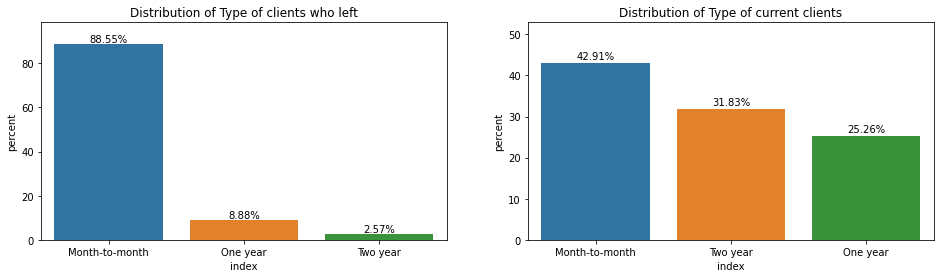

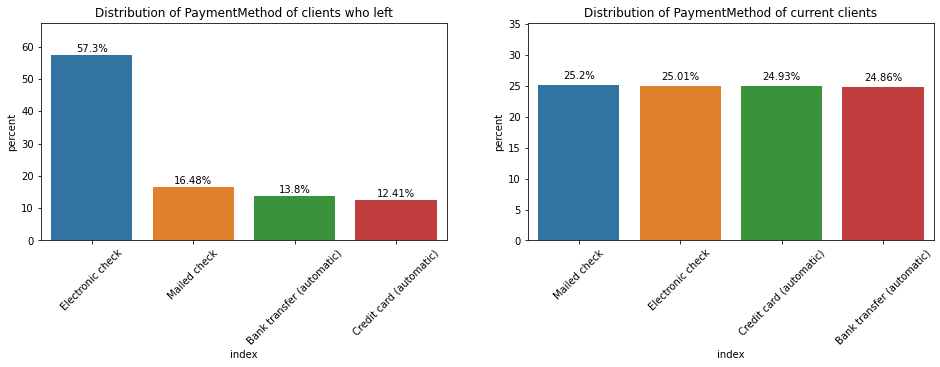

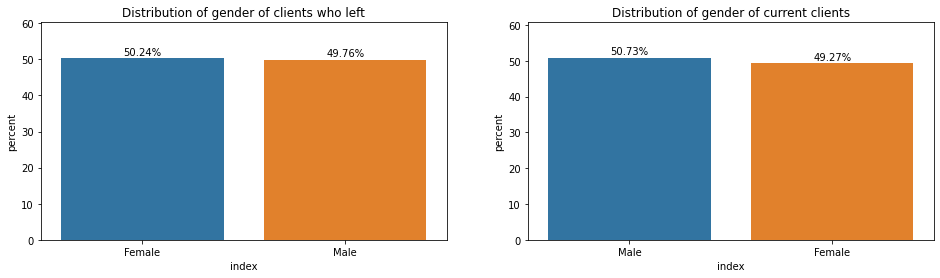

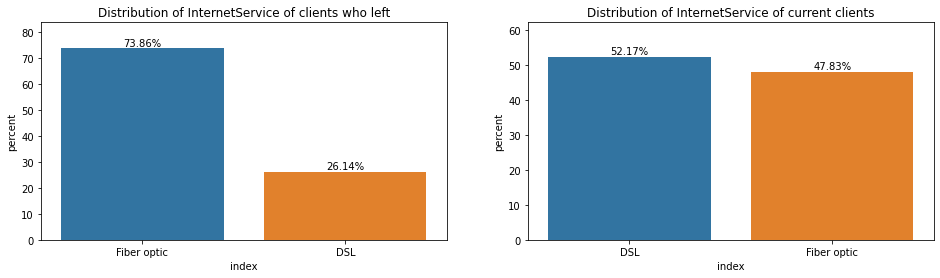

In [25]:
for cat in categorical:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
    df1 = left[cat].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    
    df2 = current[cat].value_counts(normalize=True)
    df2 = df2.mul(100)
    df2 = df2.rename('percent').reset_index()
    
    #ax1:
    
    ax1 = sns.barplot(x='index',y='percent',data=df1,ax=ax1)
    ax1.set_title(f'Distribution of {cat} of clients who left')
    ax1.set_ylim(0,df1.percent.max()+10)
    
    #annotations for ax1:
    for p in ax1.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_y = p.get_height()+1
        txt_x = p.get_x() + p.get_width()/2
        ax1.text(txt_x,txt_y,txt,ha='center')  
        
        
    #ax2:
    
    ax2 = sns.barplot(x='index',y='percent',data=df2,ax=ax2)
    ax2.set_title(f'Distribution of {cat} of current clients')
    ax2.set_ylim(0,df2.percent.max()+10)

    
    #annotations for ax1:
    for p in ax2.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_y = p.get_height()+1
        txt_x = p.get_x() + p.get_width()/2
        ax2.text(txt_x,txt_y,txt,ha='center')  
    
    if cat=='PaymentMethod':
        ax1.set_xticklabels(df1['index'],rotation=45)
        ax2.set_xticklabels(df2['index'],rotation=45)

    plt.show()

**Conclusions:**

We can see clearly the differences in the categories between clients who left and those who are still clients:
- while for the current clients their proportions in the data is rather similar for the InternetService and PaymentMethod categories, the proportions in the clients who left are very different: most clients who left used Fiber Optics (probably it's more expensive and more common these days) and the big majority who left used to have an electronic check. Only 12% and 14% left when having sort of automatic payments.

- The type of contract the client has seem to have a significant impact: almost 90% of all clients who left used a month-to-month type of contract. Seems like the tendency to leave is much smaller when the client has a 1 year or even better 2 year contract. Among the current clients the proportions are different and that's probably a good indicator to whom might want to leave soon.

- Gender doesn't seem to matter much. Among those who left there was just a slight difference of about 0.5% between the genders. The proprtions on the current clients are just slightly different, with more males than females, also this difference is very little (1.5%). 

#### EDA Numerical columns:

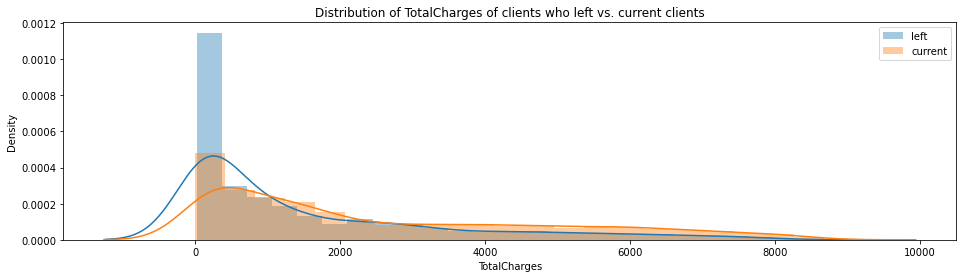

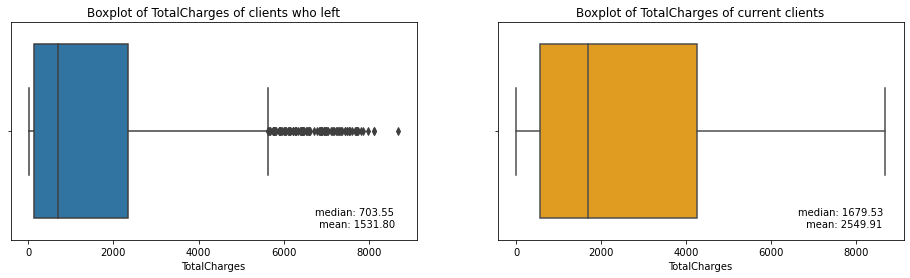

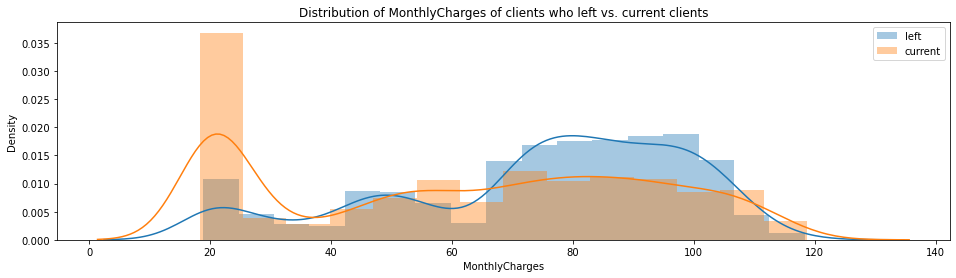

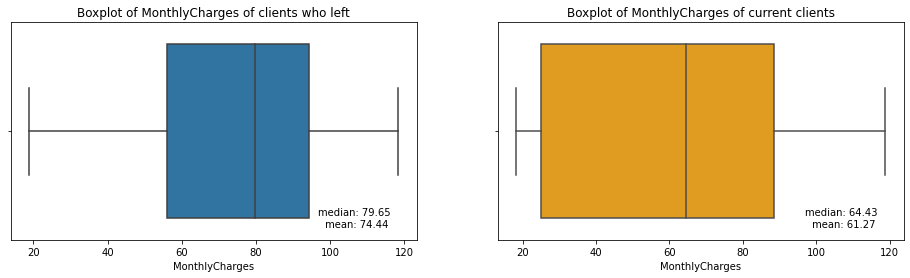

In [26]:
for col in numeric:
    plt.figure(figsize=(16,4))
    ax1 = sns.distplot(left[col], label='left',norm_hist=True)
    plt.title(f'Distribution of {col} of clients who left vs. current clients')
    
    ax2 = sns.distplot(current[col], label='current', norm_hist=True)
    plt.legend()
    
    plt.show()
    
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
    median1 = left[col].median()
    mean1 = left[col].mean()
    ax1 = sns.boxplot(left[col],ax=ax1)

    ax1.set_title(f'Boxplot of {col} of clients who left')
    ax1.text(0.85, 0.15, 'median: {:.2f} \n mean: {:.2f}'.format(median1, mean1), horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes)

    ax2 = sns.boxplot(current[col],ax=ax2,color='orange')
    mean2 = current[col].mean()
    median2 = current[col].median()
    ax2.text(0.85, 0.15, 'median: {:.2f} \n mean: {:.2f}'.format(median2, mean2), horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes)

    ax2.set_title(f'Boxplot of {col} of current clients')
    
    
    plt.show()

**Conclusions:**
- Looking at the first histogram, it's seem like those who leave choose to do that rather quickly, having quite a small amount of total charges. Those who are still clients have payed so far more.
- The boxplots confirm that, showing that the big majority who left had median total charges of 703 vs. 1679 for the current clients. The boxplot also shows some outliers for those for left and payed above around 5800 (they are therefore really not typical).


- Looking at the 2nd histogram, we can learn that those who had, the majority had rather high monthly payments, between 65 to 110. From the current clients it seems like the big majority have rather low monthly charges of around 20-25, and then still many clients in between 40-120. 
- Also here the boxplots confirm the above: the median monthly charges of those who left were almost 80, and the current clients have around 65.

#### EDA Binary columns:

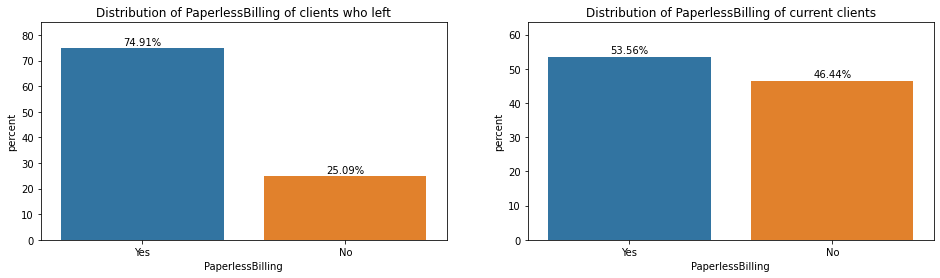

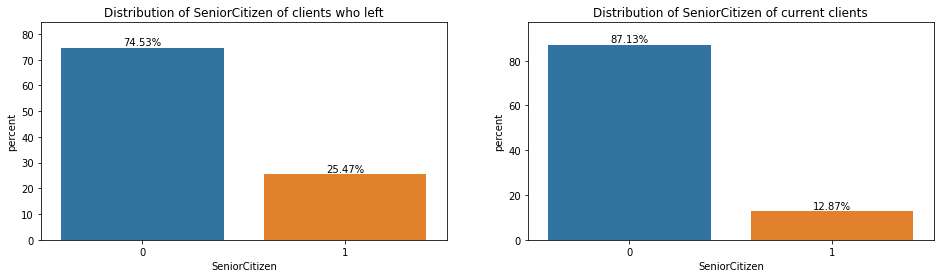

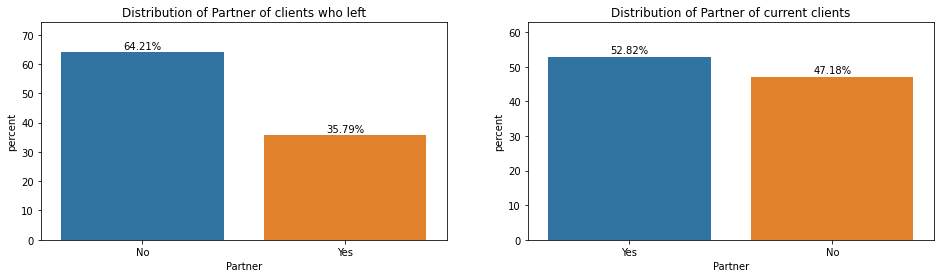

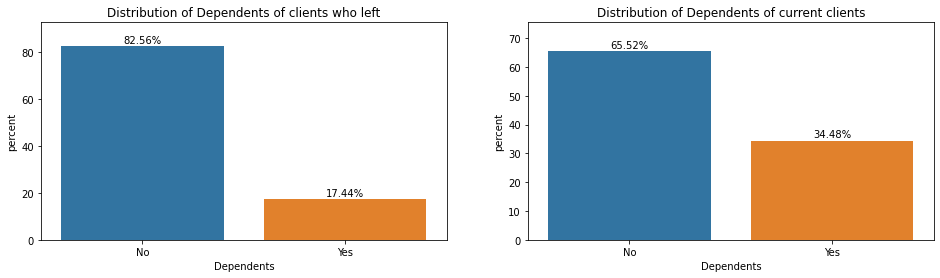

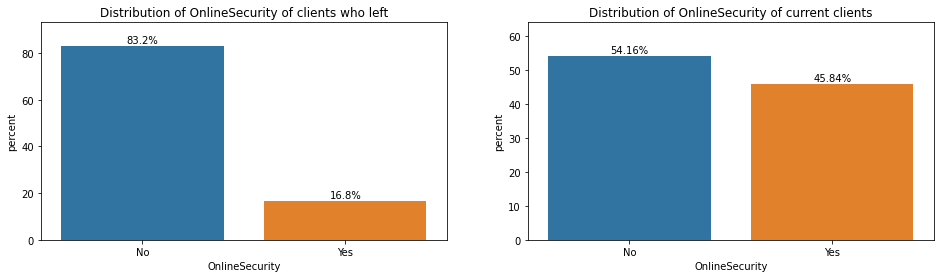

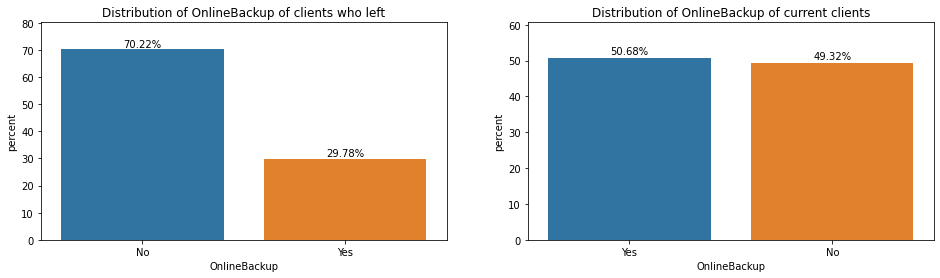

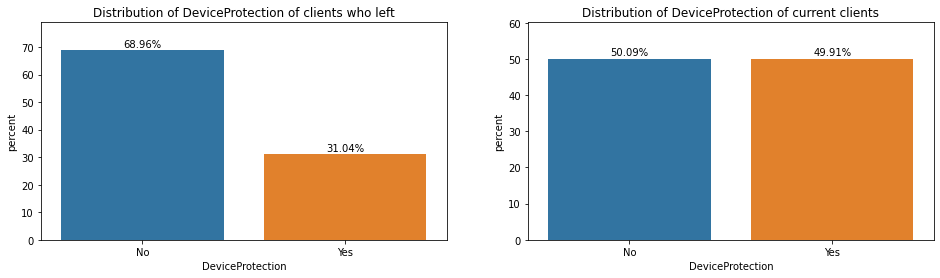

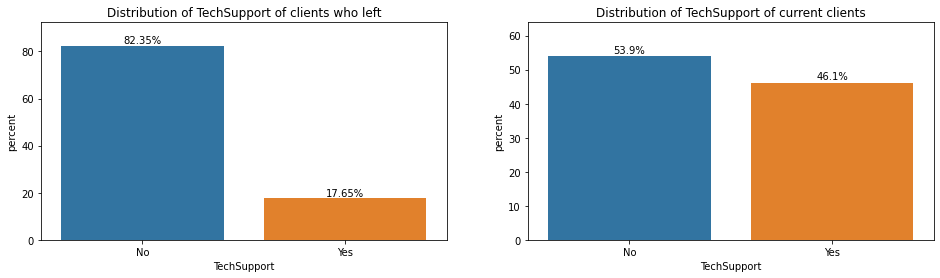

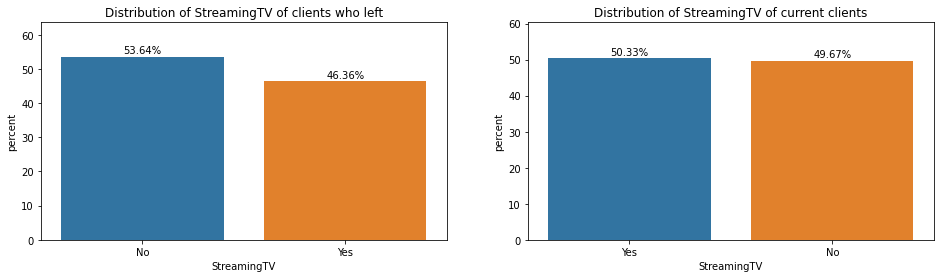

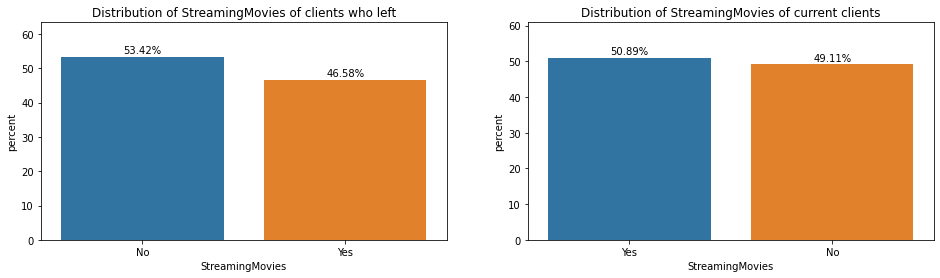

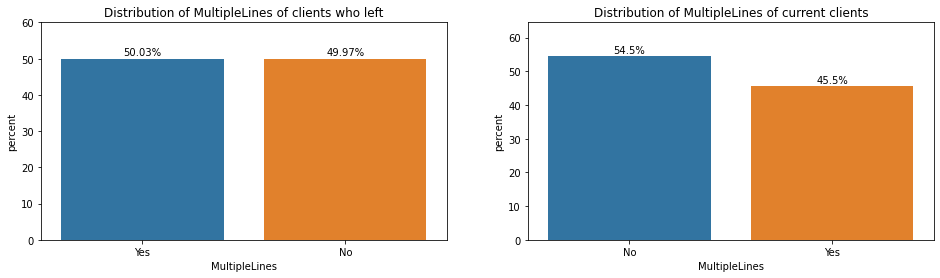

In [27]:
for col in binary:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
    df1 = left[col].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    
    df2 = current[col].value_counts(normalize=True)
    df2 = df2.mul(100)
    df2 = df2.rename('percent').reset_index()
    
    #ax1:
    
    ax1 = sns.barplot(x='index',y='percent',data=df1,ax=ax1)
    ax1.set_title(f'Distribution of {col} of clients who left')
    ax1.set_ylim(0,df1.percent.max()+10)
    ax1.set_xlabel(col)
    
    #annotations for ax1:
    for p in ax1.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_y = p.get_height()+1
        txt_x = p.get_x() + p.get_width()/2
        ax1.text(txt_x,txt_y,txt,ha='center')  
        
        
    #ax2:
    
    ax2 = sns.barplot(x='index',y='percent',data=df2,ax=ax2)
    ax2.set_title(f'Distribution of {col} of current clients')
    ax2.set_ylim(0,df2.percent.max()+10)
    ax2.set_xlabel(col)

    
    #annotations for ax1:
    for p in ax2.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_y = p.get_height()+1
        txt_x = p.get_x() + p.get_width()/2
        ax2.text(txt_x,txt_y,txt,ha='center')  
    
    if cat=='PaymentMethod':
        ax1.set_xticklabels(left[cat],rotation=45)
        ax2.set_xticklabels(current[cat],rotation=45)

    plt.show()

**Conclusions:**

I believe it's possible to divide the binary columns into columns that have significant differences for the clients who left and those that shows ambigious importance:

- Columns with significant differences:
    - TechSupport: most clients who left didn't use it.
    - DeviceProtection: most clients who left didn't use it.
    - OnlineBackup: most clients who left didn't use it.
    - OnlineSecurity: most clients who left didn't use it.
    - PaperlessBilling: Most clients who left did use this option (75%)
    
    In general, I could say that it seems like the extra services offered were not the main reason for the clients leaving, as in all of those 4 categories above, the majority of clients who left didn't use those services.
    
The next 3 categories are for the demographics of the clients:
    
    - Dependents: 82% of the clients who left have no dependents.
    - Partner: 64% have no partner (=singles)
    - SeniorCitizen: Almost 75% who left were not senior citizens.
    
**In the data unfortunately there's no exact age of the client, but nevertheless it seems like clients who are singles, without kids and who are not senior citizens might tend to terminate their contracts. They are most probably also the group which is more technological and therefore prefer to get a paperless bill. The extra services offered don't seem to be the reason in the majority of the cases to terminate the contracts.**


- Columns with ambigious signifiance:
    - MultipleLines: 50%-50%. Seems like having more lines or just one is not affecting whether someone stays or leaves.
    - StreamingMovies: 53%-47% - Most do not use it, but still a big part from those who leave do use this service.
    - StreamingTV: 54%-46% - Most do not use it, but still a big part from those who leave do use this service.

In [28]:
display(f'The clients who left represent {len(left)*100/len(df):.2f}% of all clients')
display(f'The current clients represent {len(current)*100/len(df):.2f}% of all clients')


'The clients who left represent 26.54% of all clients'

'The current clients represent 73.46% of all clients'

**Conclusion:**
- The data is unbalanced: There are much more current clients than those who left. 

The merge of the 4 datasets has created missing values:

In [29]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

### Feature engineering:

We have the date the clients started their contract and also the end date (if terminated the contract) or 'no' if still a client. As passing dates to build the model is problematic, I'd rather create an extra columns with the period of time the client is/was a client (in days). If 'No' is the value in the EndDate column, then it could be replaced with today's date (February 1, 2020).

In [30]:
df['EndDate_dt'] = pd.to_datetime(df['EndDate'].apply(lambda x:'2020-02-01 00:00:00' if x=='No' else x))

In [31]:
df['ContractDays'] = df['EndDate_dt'] - df['BeginDate']
df['ContractDays'] = (df['ContractDays'] / np.timedelta64(1, 'D')).astype(int)

In [32]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_dt,ContractDays
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,2019-11-01,61


#### Creating the target column:

I'd like to flag the clients who are in risk of terminating their contract and leave the company, therefore, for creating a model I'll create a target churn column that will mark these clients as 1 and all the rest as 0:

In [33]:
df['churn'] = df['EndDate'].apply(lambda x:0 if x=='No' else 1)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_dt,ContractDays,churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Yes,No,No,No,No,NaN,2020-02-01,31,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,Yes,No,No,No,No,2020-02-01,1036,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,No,2019-12-01,61,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,No,Yes,Yes,No,No,NaN,2020-02-01,1371,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,No,2019-11-01,61,1


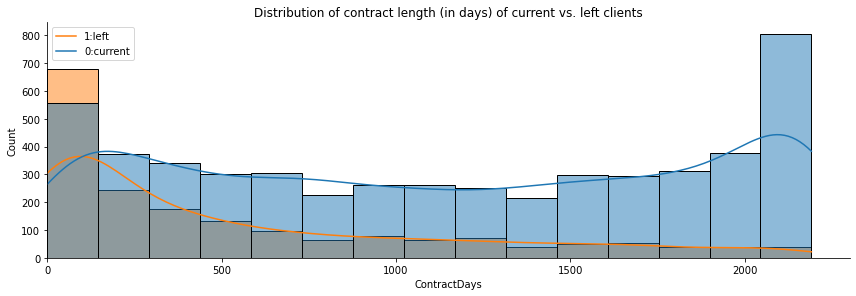

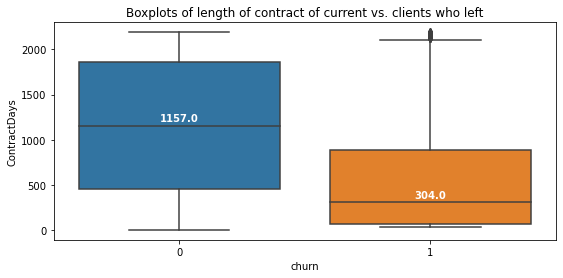

In [34]:
#plotting histograms and boxplots with the ContractDays feature:
sns.displot(data=df, x='ContractDays',label='Clients', bins='auto', hue='churn',kde=True,height=4, aspect=3,legend=False)
plt.xlim(0)
plt.legend(['1:left','0:current'])
plt.title('Distribution of contract length (in days) of current vs. left clients')
plt.show()

plt.figure(figsize=(9,4))
box = sns.boxplot(data=df, y='ContractDays',x='churn')


medians = df.groupby(['churn'])['ContractDays'].median()
vertical_offset = df['ContractDays'].median() * 0.05 # offset from median for display

for xtick in box.get_xticks():
    box.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
    
    
plt.title('Boxplots of length of contract of current vs. clients who left')
plt.show()

Now that we have the length of contract, we can compare as well how long it typically takes for those who leave: the longer one has a contract the least they leave. From the boxplots we can also see that the median period for a client who left is 304 days while among the current client the median is 1157 days. 

There are just few outliers in the churn=1 group (clients who left) and they represent very rare clients who left after extremely long time as a client (above 2000 days).

### Final EDA conclusions and next steps for modelling:

I've received 4 datasets with various information about current and previous clients of the telecom operator Interconnect. After a quick investigation of the 4 datasets I concluded that I could merge the 4 into 1 extended dataset, based on the unique ClientID provided in all datasets.

My task is to identify current clients who might want to leave the company soon, in order to contact them in advance, offering them various promotions in order to keep them longer and prevent them from leaving.

After merging the data I could investigate further the full data and could reach some key conclusions, by analyzing the data of the clients who left vs. the current clients and build a type of a persona who has higher potential to want to leave the company:
- clients with month-to-month contracts, singles, non seniors who are probably more tech-oriented (paperless bills), with electronic check and rather low monthly fees and relateively new clients tend to terminate they contracts earlier. 
- there are some features in the data that seems to not have much affect such as gender and having multiple lines.

#### Next steps: preparation for modelling:

In order the create a model, I'd need a model that would flag those clients who might be soon leaving. That would be a binary classification where 0 are the clients who stay and 1 the clients who would leave. I'll try various types of models and believe one type that might be very useful in our case would be using a KNN model - as it finds neighboring samples and could help detecting similar clients to those who left already.

As we saw earlier, the data is not balanced and there might be a need to down/upscale the data. The data will therefore be splitted into stratified training/testing datasets (stratify in order to keep the original balance in the datasets).
Few columns will be dropped as well (the datetime columns and the ClientID).

For the modelling the next steps will be necessary and will be all implemented through a pipeline:
- Removing outliers (ideally would try building with/without the outliers noticed earlier to see if there's any effect)
- Imputing missing values
- normalizing the numerical features
- transforming the categorical features into numbers (One-Hot-Encoding or get_dummies)
- transforming all binary features into numbers (Binary encoding)
- cross-validation on few simple models to assess which model does better
- cross-validation with down/upscaled data as well
- GridSearchCV/RandomizedSearchCV/BayessearchCV for tuning various hyperparameters and improving the model.

- creating a dummy model to be able to compare the results with the most basic dummy model.

**Metrics to be used:** As we have an unbalanced classification problem 'accuracy' might be not realible for assessing the results. Therefore, roc-auc score will be primarily used, together with 'accuracy' and f1 score. 




### Modelling:

In [35]:
!pip install -U category_encoders

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_auc_score as roc_auc, f1_score as f1, accuracy_score as accuracy
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer

import category_encoders as ce


In [37]:
!pip install -U Scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [38]:
#declaring the columns to be removed from the data for the modelling:
drop_col = ['churn', 'customerID','BeginDate','EndDate','EndDate_dt']
numeric.append('ContractDays')

ordinal = ['MultipleLines']
binary.remove('MultipleLines')  

In [39]:
#splitting the data to X and y for training/test:
X_train, X_test, y_train, y_test = train_test_split(df.drop(drop_col,axis=1),df['churn'], test_size=0.2, stratify= df['churn'], random_state=123)

In [40]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='none')),
    ('ordinal_enconding', OrdinalEncoder(categories=[['none', 'No', 'Yes']])),
    ('scale', MinMaxScaler())
    
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoding', ce.BinaryEncoder(return_df=True))
])

binary_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='No')),
    ('binary_encoding', ce.BinaryEncoder(return_df=True)),
    
    
])
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric),
    ('category', categorical_pipeline, categorical),
    ('binary', binary_pipeline, binary),
    ('ordinal', ordinal_pipeline, ordinal)
])

In [41]:
full_processor.fit_transform(X_train)[2]

array([0.18931213, 0.05970149, 0.95937928, 0.        , 1.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       0.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 1.        ])

The processor works well.

#### Dummy Classifier:

In [42]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print(f'Dummy Roc-Auc: {roc_auc(y_test,dummy_clf.predict_proba(X_test)[:,1])}')
print(f'Dummy accuracy score: {accuracy(y_test,dummy_clf.predict(X_test)):.3f}')

Dummy Roc-Auc: 0.5
Dummy accuracy score: 0.735


#### KNClassifier:

In [43]:
%%time
KNN = KNeighborsClassifier()

knn_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', KNN)
])

knn_model = knn_pipeline.fit(X_train,y_train)

CV_result_knn = (cross_val_score(knn_pipeline, X_train, y_train, cv=3,scoring='roc_auc').mean())
print(f'Cross-validation average roc-auc result on the training data: {CV_result_knn:.3f}')
print()

Cross-validation average roc-auc result on the training data: 0.771

Wall time: 1 s


#### Random Forest Classifier:

In [44]:
%%time
RF = RandomForestClassifier()

rf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', RF)
])

rf_model = rf_pipeline.fit(X_train,y_train)

CV_result_knn = (cross_val_score(rf_pipeline, X_train, y_train, cv=3,scoring='roc_auc').mean())
print(f'Cross-validation average roc-auc result on the training data: {CV_result_knn:.3f}')
print()

Cross-validation average roc-auc result on the training data: 0.843

Wall time: 1.9 s


#### GradientBoostingClassifier:

In [45]:
%%time
from sklearn.ensemble import GradientBoostingClassifier


GBC = GradientBoostingClassifier(random_state=123)

GBC_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', GBC)
])

GBC_model = GBC_pipeline.fit(X_train,y_train)

CV_result_knn = (cross_val_score(GBC_pipeline, X_train, y_train, cv=3,scoring='roc_auc').mean())
print(f'Cross-validation average roc-auc result on the training data: {CV_result_knn:.3f}')
print()

Cross-validation average roc-auc result on the training data: 0.883

Wall time: 2.85 s


In [46]:
gbc_param_grid = {
    
    'model__learning_rate': Real(0.05,1, 'log-uniform'),
    'model__max_depth': Integer(3, 10, 'log-uniform'),
    'model__n_estimators': Integer(50, 200, 'log-uniform'),
    'model__min_samples_leaf' :Integer(1,10, 'log-uniform'),
    #'model__alpha': Integer(1,20,'log-uniform')
}

# Perform RandomizedSearchCV
GBC_Bayes = BayesSearchCV(GBC_pipeline,search_spaces=gbc_param_grid,n_iter=2, scoring='roc_auc',verbose=0,cv=3, random_state=123)

GBC_Bayes.fit(X_train,y_train)

print(f'Roc-Auc CV score on the training data: {GBC_Bayes.best_score_:.3f}')


Roc-Auc CV score on the training data: 0.887


#### XGB model:

In [47]:
#!pip install xgboost

In [48]:
import xgboost as xgb

In [49]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic")

xgb_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', xgb_clf)
])

In [50]:
%%time

xgb_model = xgb_pipeline.fit(X_train,y_train)

CV_result_xgb = (cross_val_score(xgb_model, X_train, y_train, cv=3,scoring='roc_auc').mean())
print(f'Cross-validation average roc-auc result on the training data: {CV_result_xgb:.3f}')
print()


[19:56:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Hyperparameters tuning with BayesSearchCV:

In [104]:
gbm_param_grid = {
    
    'model__learning_rate': Real(0.05,1, 'log-uniform'),
    'model__max_depth': Integer(3, 10, 'log-uniform'),
    'model__n_estimators': Integer(50, 200, 'log-uniform'),
    'model__eta' :Real(0.1,0.5, 'log-uniform'),
    'model__colsample_bytree': Real(0.1,0.5,'log-uniform'),
}

# Perform RandomizedSearchCV
xgb_Bayes = BayesSearchCV(xgb_pipeline,search_spaces=gbm_param_grid,n_iter=2, scoring='roc_auc',verbose=0,cv=3, random_state=123)

xgb_Bayes.fit(X_train,y_train)
print(f'Roc-Auc score on the BayesSearchCV training data: {xgb_Bayes.best_score_:.3f}')


[20:15:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [105]:
pred_prob = xgb_Bayes.predict_proba(X_test)[:,1]
pred = xgb_Bayes.predict(X_test)
print(f'ROC-AUC on the test data: {roc_auc(y_test,pred_prob):.3f}')
print(f'Accuracy on the test data: {accuracy(y_test, pred):.3f}')
print(f'F1 score on the test data: {f1(y_test, pred):.3f}')

ROC-AUC on the test data: 0.898
Accuracy on the test data: 0.851
F1 score on the test data: 0.689


- Excellent results on the test dataset with XGBoost.

#### Down/Upscaling the data:

In [53]:
from sklearn.utils import resample

In [54]:
def upscale(df):
    # Separate majority and minority classes
    df_majority = df[df.churn==0]
    df_minority = df[df.churn==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    display(df_upsampled.churn.value_counts(normalize=True))
    display(df_upsampled.shape)
    
    return df_upsampled

In [55]:
def downscale(df):
    # Separate majority and minority classes
    df_majority = df[df.churn==0]
    df_minority = df[df.churn==1]

    # Upsample minority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=True,     # sample with replacement
                                     n_samples=df_minority.shape[0],    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    display(df_upsampled.churn.value_counts(normalize=True))
    display(df.shape)
    
    return df_upsampled

- In order to avoid data leakage when down/upsampling, I'll apply the process to the training data only, leaving the test data untouched (it's the same testing data as the earlier models used):

In [56]:
train, test = train_test_split(df, test_size=0.2, stratify= df['churn'], random_state=123)

In [57]:
display(train['churn'].value_counts(normalize=True))
display(train.shape)

0    0.734647
1    0.265353
Name: churn, dtype: float64

(5634, 23)

In [58]:
df_upsampled = upscale(train)

X_train_upscale = df_upsampled.drop(drop_col,axis=1)
y_train_upscale = df_upsampled['churn']

0    0.5
1    0.5
Name: churn, dtype: float64

(8278, 23)

In [59]:
df_downsampled = downscale(train)

X_train_downscale = df_downsampled.drop(drop_col,axis=1)
y_train_downscale = df_downsampled['churn']

0    0.5
1    0.5
Name: churn, dtype: float64

(5634, 23)

In [60]:
!pip install -U imbalanced-learn


In [61]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as Ppl
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, NearMiss

In [62]:
rnne = RepeatedEditedNearestNeighbours()
near = NearMiss()
smt = SMOTE(random_state=123)

#### upsampling with SMOTE:

In [63]:
xgb_pipeline_smote = Ppl(steps=[
    ('preprocess', full_processor),
    ('smote', smt),
    ('model', xgb_clf)
])

xgb_param_grid = {
    
    'model__learning_rate': Real(0.05,1, 'log-uniform'),
    'model__max_depth': Integer(3, 10, 'log-uniform'),
    'model__n_estimators': Integer(50, 200, 'log-uniform')
}

# Perform RandomizedSearchCV
xgb_Bayes_upscaled = BayesSearchCV(xgb_pipeline_smote,search_spaces=xgb_param_grid,n_iter=2, scoring='roc_auc',verbose=0,cv=3, random_state=123)

xgb_Bayes_upscaled.fit(X_train,y_train)

print(xgb_Bayes_upscaled.best_score_)
#print(catb_Bayes.best_estimator_)

[19:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [64]:
pred_prob = xgb_Bayes_upscaled.predict_proba(X_test)[:,1]
pred = xgb_Bayes_upscaled.predict(X_test)
print(f'Roc-Auc score on the test data and training on upscaled data: {roc_auc(y_test,pred_prob):.3f}')
print(f'Accuracy score on the test data and training on upscaled data: {accuracy(y_test,pred):.3f}')
print(f'F1 score on the test data and training on upscaled data: {f1(y_test,pred):.3f}')


Roc-Auc score on the test data and training on upscaled data: 0.889
Accuracy score on the test data and training on upscaled data: 0.843
F1 score on the test data and training on upscaled data: 0.689


#### Downsampling with RNNE:

In [65]:

xgb_pipeline_rnne = Ppl(steps=[
    ('preprocess', full_processor),
    ('rnne', rnne),
    ('model', xgb_clf)
])

xgb_param_grid = {
    
    'model__learning_rate': Real(0.05,1, 'log-uniform'),
    'model__max_depth': Integer(3, 10, 'log-uniform'),
    'model__n_estimators': Integer(50, 200, 'log-uniform')
}

# Perform RandomizedSearchCV
xgb_Bayes_downscaled = BayesSearchCV(xgb_pipeline_rnne,search_spaces=xgb_param_grid,n_iter=2, scoring='roc_auc',verbose=0,cv=3, random_state=123)

xgb_Bayes_downscaled.fit(X_train,y_train)

print(xgb_Bayes_downscaled.best_score_)
#print(catb_Bayes.best_estimator_)

[19:56:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:56:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [66]:
pred_prob = xgb_Bayes_downscaled.predict_proba(X_test)[:,1]
pred = xgb_Bayes_downscaled.predict(X_test)
print(f'Roc-Auc score on the test data and training on upscaled data: {roc_auc(y_test,pred_prob):.3f}')
print(f'Accuracy score on the test data and training on upscaled data: {accuracy(y_test,pred):.3f}')
print(f'F1 score on the test data and training on upscaled data: {f1(y_test,pred):.3f}')


Roc-Auc score on the test data and training on upscaled data: 0.827
Accuracy score on the test data and training on upscaled data: 0.681
F1 score on the test data and training on upscaled data: 0.597


**Conclusion:**
- up/downsampling the data didn't improve the results through the CV.

### Model without outliers

I've seen earlier that there might be some outliers that would be uncharachteristic for the clients who left. I'll try to remove them (from the test data only), and will re-train the model with the data without them:

In [67]:
idx_to_remove = train[(train['TotalCharges']>6000) & (train['churn']==1)].index
X_train_no_outliers = train.drop(index=idx_to_remove).drop('churn', axis=1)
y_train_no_outliers = train.drop(index=idx_to_remove)['churn']

In [74]:
xgb_param_grid = {
    
    'model__learning_rate': Real(0.05,1, 'log-uniform'),
    'model__max_depth': Integer(3, 10, 'log-uniform'),
    'model__n_estimators': Integer(50, 200, 'log-uniform'),
}

# Perform RandomizedSearchCV
xgb_Bayes_outliers = BayesSearchCV(xgb_pipeline,search_spaces=xgb_param_grid,n_iter=2, scoring='roc_auc',verbose=0,cv=3, random_state=123)

xgb_Bayes_outliers.fit(X_train_no_outliers,y_train_no_outliers)

print(xgb_Bayes_outliers.best_score_)
#print(catb_Bayes.best_estimator_)

[20:03:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [69]:
pred_prob = xgb_Bayes_outliers.predict_proba(X_test)[:,1]
pred = xgb_Bayes_outliers.predict(X_test)
print(f'Roc-Auc score on the test data and training on upscaled data: {roc_auc(y_test,pred_prob):.3f}')
print(f'Accuracy score on the test data and training on upscaled data: {accuracy(y_test,pred):.3f}')
print(f'F1 score on the test data and training on upscaled data: {f1(y_test,pred):.3f}')


Roc-Auc score on the test data and training on upscaled data: 0.874
Accuracy score on the test data and training on upscaled data: 0.848
F1 score on the test data and training on upscaled data: 0.679


**Conclusion:**
- Removing the outliers has improved the training CV results a little bit, but the results on the test set are still better when the model is trained with the outliers.

### Modelling conclusions:

I have tried various models with various different parameters, including up/downscaled data. The best model achieved was able to differenciate between clients who left and are still clients with the results mentioned above.

The key steps of each model's pipeline were:

- filling the missing values:
    - categorical values with "unknown"
    - numerical with the average value of the column
    - binary with "No"
    - ordinal with "none" (that will map to 0)
    
- normalizing the data and transforming all object features into numerical features:
    - Numerical columns with MaxMinScaler
    - Binary and Categorical columns with BinaryEncoder
    - Ordinal columns with OrdinalEncoder and then with StandardScaler

I was trying as well to remove outliers and check whether up/downscaling the data might improve the results. The results though didn't improve on the test dataset, and the original training data used through the pipeline seemed to have yielded the best results on the test dataset.

### Final Report:

I have received historical data of clients of the phone company, including data of their usage, personal information and packages to which they had contracts. In addition, the data provided information about who is currently a client and who left already and is no longer a client. My task was to analyse the data and build a model that will help to decide which client might leave soon (churn), in order to contact him/her in advance and prevent them from leaving by offering various promotions.

Through my EDA analysis I could recognize that "clients with month-to-month contracts, singles, non seniors who are probably more tech-oriented (paperless bills), with electronic check and rather low monthly fees and relateively new clients tend to terminate they contracts earlier." 

The modelling plan included steps as mentioned above: filling the missing values according to the kind of the feature (binary,categorical, numerical and ordinal), encoding the data if needed (binary/ordinal), normalizing the data for better modelling results and as well later on adding balancing techniques to up/downscale the data (as the data was found to be unbalanced).

I've created as well a dummy model in order to have a baseline score to relate to and few types of model were tested, including cross validation and hyperparameters tuning with the help of a BayesSearchCV. Eventually also up/downscaled data was tested and data without outliers that were detected through the EDA.

The best model achieved was an XGBoost model, with the following scores and hyperparameters:

In [70]:
xgb_Bayes.best_params_

OrderedDict([('model__colsample_bytree', 0.49401528441178183),
             ('model__eta', 0.3414881545990261),
             ('model__learning_rate', 0.6126417675370945),
             ('model__max_depth', 3),
             ('model__n_estimators', 99)])

- ROC-AUC on the test data: 0.898
- Accuracy on the test data: 0.851
- F1 score on the test data: 0.689

Eventually after some trial an error with an unsupervised approach I've decided to drop it and not to include in the notebook. Clustering did show that there are overlapping clusters between those who are still clients and those who have left, but the analysis didn't shed new light or could detect new information that wasn't already presented through the EDA earlier on. 

Some challenges I've come up with included integrating all of those steps above into one smooth working pipeline, that took a bit of time till everything was working properly. In addition, avoiding data leakage was as something I had to make sure that is prevented, and I managed to do that through splitting the data into train-test early in the process, basically not applying any changes to the test data after that, and making sure that through the CV when up/downscaling the data, that it is applied only to the relevant fold and not the whole training dataset. 